# Identifying a problem

Rates of diabetes is increasing. Is there a way we can identify diabetes in an undiagnosed patient, or even diagnose it before they acquire it?

# Ideating a model that leverages pertinent data

By using various statistics of previous patients and their readings related to sugar level, such as insulin level, as our independent variables, in addition to whether the patient was actually diabetic or not as our outcome variable (binary),  we can create a classifier model that can predict (the outcome variable) from (the independent variables).


# Loading the data

This method involves uploading the datasets to Google Drive, and the following code is simply making that dataset visible and extractable to this notebook.

In [3]:
#Connecting to Google Drive for dataset access
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'1ABhwf0KVUD9wu7FaiLmxy2G2RZiYOrEy' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  

    100% |████████████████████████████████| 993kB 11.6MB/s 
title: diabetes, id: 1aHdRAdXo-uARANOAP49aXUPhWOJ9C4K4


In [20]:
def get_data_set():
  requested_dataset_name = input().lower()
  requested_dataset_id = 0
  
  for file in file_list:
    if file['title'].lower() == requested_dataset_name:
      requested_dataset_id = file['id']
      break
      
  if requested_dataset_id == 0:
    raise FileNotFoundError('1','No dataset with the name ' + requested_dataset_name + ' could be found. Are you in the correct folder?')
  
  data = drive.CreateFile({'id': requested_dataset_id})
  data.GetContentFile(requested_dataset_name)
  
  import pandas as po
  dataset=po.read_csv(requested_dataset_name)
  return dataset

dataset = get_data_set()

dataset.head(5)
  

diabetes


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [0]:
# Alternate dataset retrieval using SQL syntax in progress

# Conducting data exploration

A good habit is to familiarize yourself with the type of data that is provided. The dataset may have missing values, incorrectly typed columns, or have data that are more suited towards a specific type of model (classification or regression; this may lead to further analysis of the columns to see if there is multicollinearity, and so on...). In addition, alhough we already have an idea for creating a model already, sometimes the dataset will not initially have clear-cut features, or features that will lead to a good model. So, data exploration is necessary to see if:

1) The data needs to be further cleaned

2) New features can be created from the existing features

3) Novel patterns/trends can be detected

In [8]:
import pandas as po
import numpy as no

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


While there are certainly some interesting figures here (who gave 17 pregnancies??) The values all seem rather normal and complete.

In [10]:
dataset.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


(Keep in mind, sometimes the outcome variable will be binary, but not numerical. In these instances, the corr() function will not work. The outcome variable must first be converted to numerical values, which, in this case, is 0 and 1)

Seaborn is a powerful data visualization package, closely tied with Pandas. Compare the correlation matrix from the Pandas module (above) to Seaborn's (below)! Note that Seaborn actually uses Pandas' correlation matrix as a parameter.

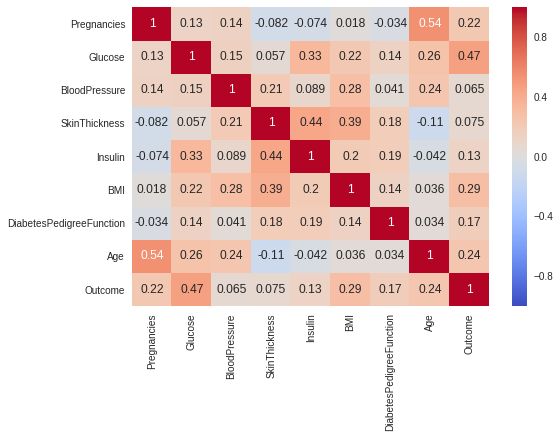

In [11]:
import seaborn as sbo

sbo.heatmap(dataset.corr(),annot = True, cmap = 'coolwarm')

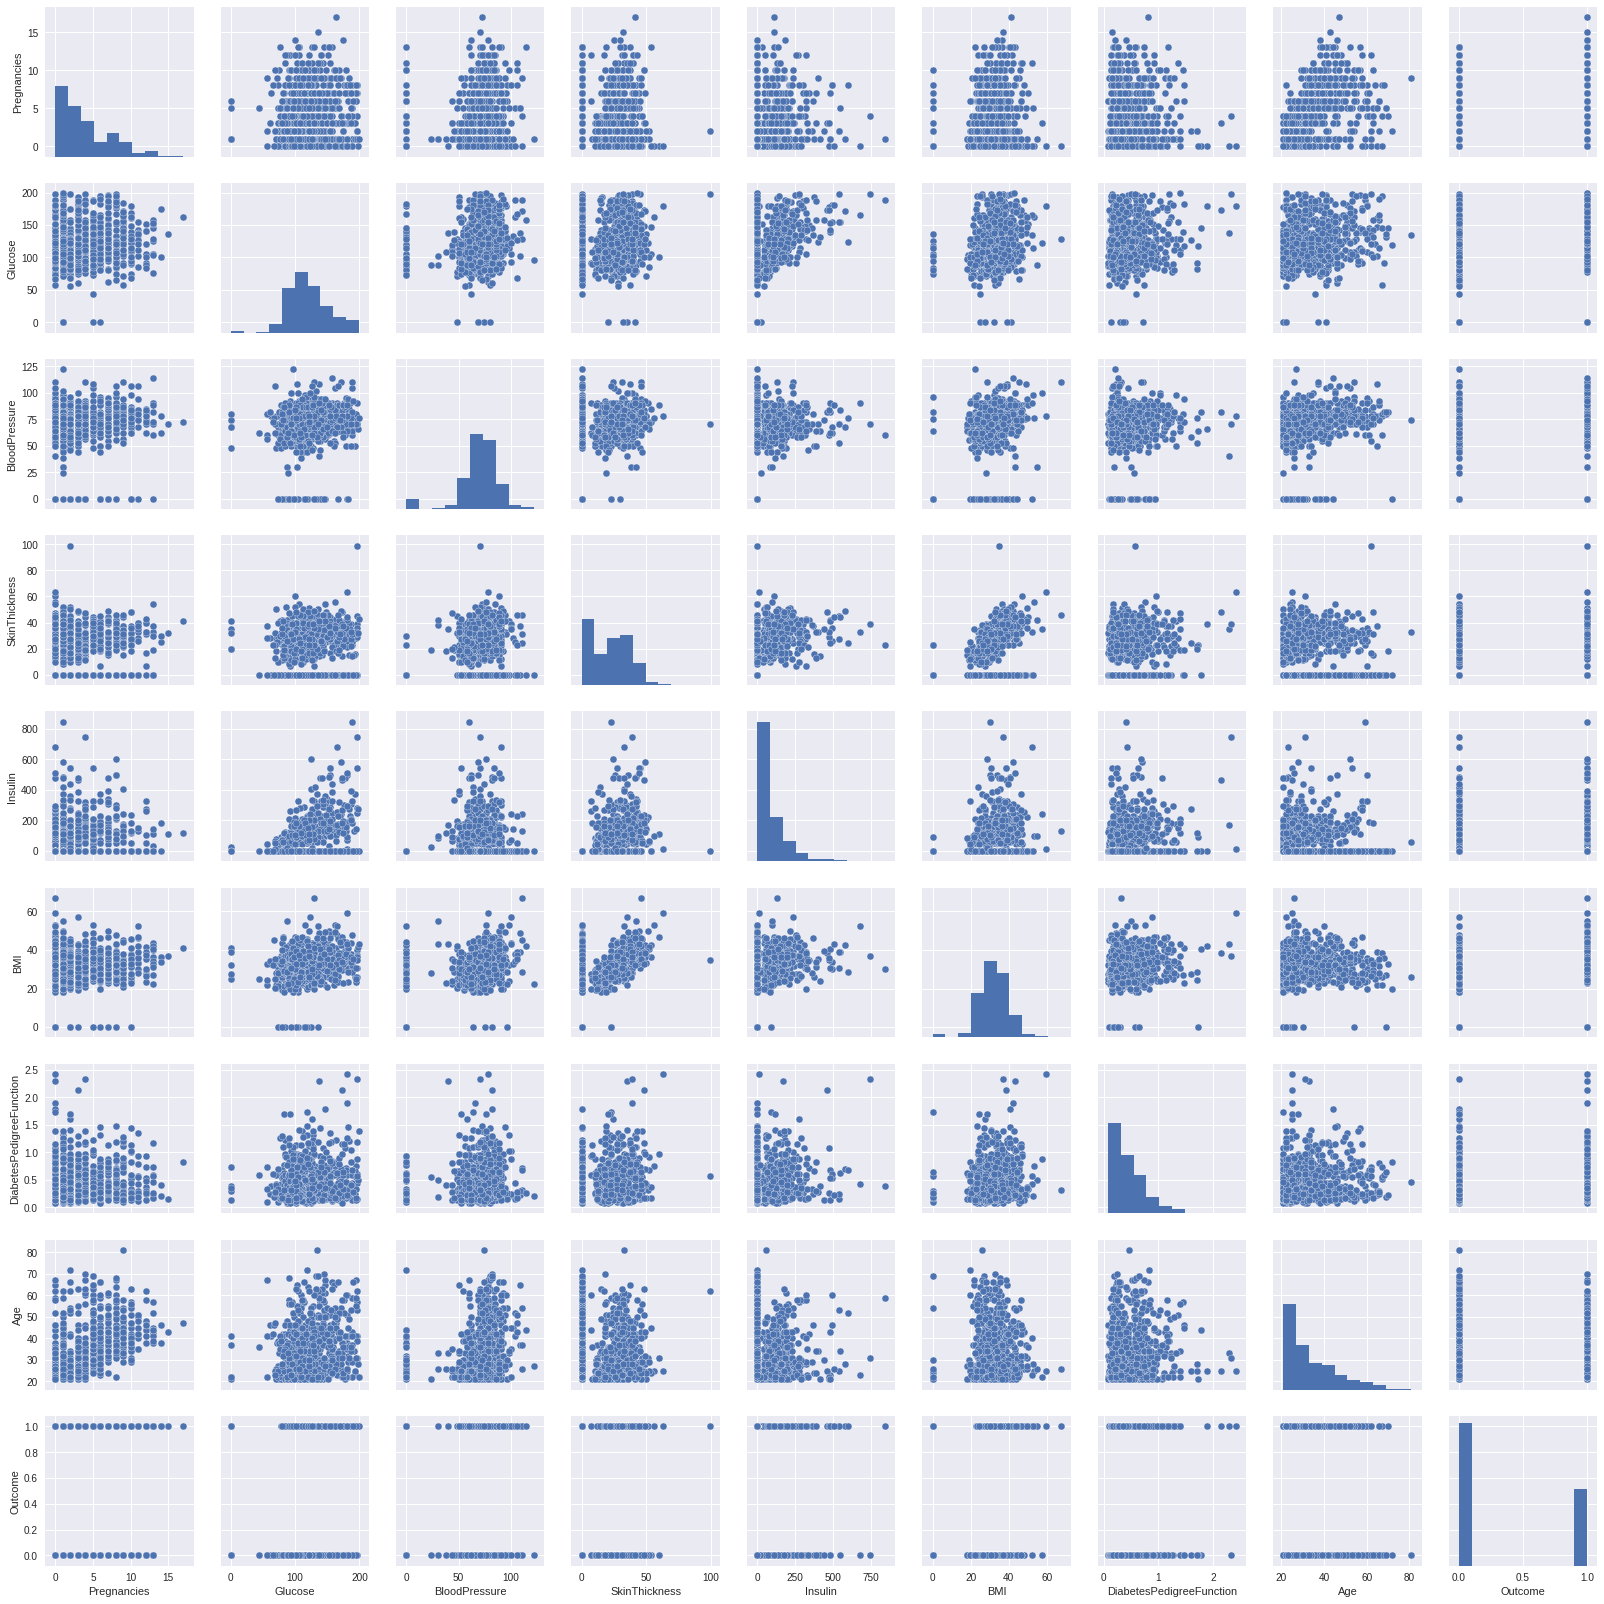

In [12]:
sbo.pairplot(dataset)

While there are certainly intriguing correlations here (skin thickness and age, for instance), what interests us the most is the last column/row which focuses on correlation values between the independent variables and the outcome variable. We see that glucose readings have the highest correlation with the patients' diabetes status. This will most likely be a good feature to include in our model.

# Developing a model

Testing a model's effectiveness is often done by first training a model with a majority of the data, and testing it on the rest of the initially witheld data.

In [0]:
from sklearn.model_selection import train_test_split

train,test=train_test_split(dataset,test_size=0.25,random_state=0)

# Features selected for model development
features = ["Age", "Insulin", "BMI"] 

# Training Data
training_data = train[features]
training_label = train['Outcome']

# Testing Data
testing_data = test[features]
testing_label = test['Outcome']

There are several common models (found below). The model that scores the best according to your metrics (in this case, accuracy) should be considered. Of course, for specific types of problems and other real-world considerations, certain models may be inherently better than others (e.g. regression and time-series data; decision trees are easy to understand and explain to clinicians, who base their own decisions in a similar logic).

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dt_model = DecisionTreeClassifier()
dt_model.fit(training_data,training_label)
dt_prediction = dt_model.predict(testing_data)
dt_acc = metrics.accuracy_score(dt_prediction,testing_label)
print('The accuracy of the Decision Tree is',dt_acc)

The accuracy of the Decision Tree is 0.6614583333333334


In [25]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver = "lbfgs")
lr_model.fit(training_data,training_label)
lr_prediction = lr_model.predict(testing_data)
lr_acc = metrics.accuracy_score(lr_prediction,testing_label)
print('The accuracy of the Logistic Regression is',lr_acc)

The accuracy of the Logistic Regression is 0.6770833333333334


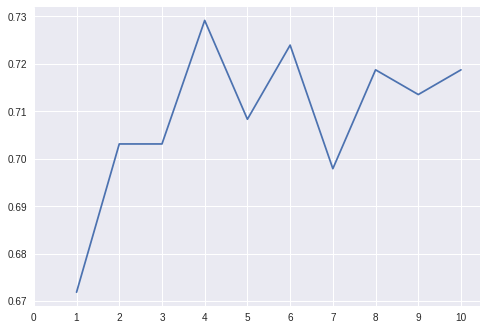

Accuracies for different values of n are: [0.671875   0.703125   0.703125   0.72916667 0.70833333 0.72395833
 0.69791667 0.71875    0.71354167 0.71875   ]


In [27]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

a_index = list(range(1,11))
a = po.Series()
for i in list(range(1,11)):
    kn_model=KNeighborsClassifier(n_neighbors=i) 
    kn_model.fit(training_data,training_label)
    kn_prediction=kn_model.predict(testing_data)
    a = a.append(po.Series(metrics.accuracy_score(kn_prediction,testing_label)))
    
x = [0,1,2,3,4,5,6,7,8,9,10]
plt.plot(a_index, a)
plt.xticks(x)
plt.show()
print('Accuracies for different values of n are:',a.values)

In [30]:
from sklearn import svm
types=['rbf','linear']
for i in types:
    svm_model=svm.SVC(kernel=i, gamma = "auto")
    svm_model.fit(training_data,training_label)
    svm_prediction=svm_model.predict(testing_data)
    svm_acc=metrics.accuracy_score(svm_prediction,testing_label)
    print('Accuracy for SVM kernel=',i,'is',svm_acc)


Accuracy for SVM kernel= rbf is 0.6666666666666666
Accuracy for SVM kernel= linear is 0.6666666666666666


In an effort to increase the accuracy, consider changing the features we trained our models on.

# Conclusion

Before presenting your research, you should think of the real-world implications of your findings. For instance, a researcher develops an extremely complex neural network that has a significantly greater accuracy than the model presented here (let's say, 80% to our 70%). The goal is to integrate a classification model into standard hospital procedues. However, when trying to explain to the clinicians how the model bases its decisions, he is at a loss for words, and therefore his model is not accepted. As Dr. Shawn Sturland of MIT's Laboratory for Computational Physiology once put it: "“It doesn’t do a clinician any good if they can’t explain to their patient how this machine decided their treatment.”

Don't worry if your research isn't groundbreaking in and of itself; As long as you are ambitious and have a large-picture goal, selecting and answering a question with the next two, three, even four questions already in mind is key. Gradually, your work will scale the significance of your results and bring you to your goal/the large-scale problem you initially wanted to address.
